## Challenge of deep learning 

### Sensor (by Sensor Logger APP)

- 11 Sensors data are collected: 'TotalAcceleration' (only in android), 'Barometer', 'Location', 'Orientation', '**Magnetometer**', 'GyroscopeUncalibrated', 'MagnetometerUncalibrated', '**Accelerometer**', 'AccelerometerUncalibrated', '**Gyroscope**', '**Gravity**'

- We should **use only the calibrated data.** Sensor Logger gives you the option to log raw, uncalibrated data from the accelerometer, gyroscope and magnetometer. Calibrated data is always logged. The raw stream is useful for performing lower-level post-processing or custom sensor fusion. If in doubt, **always use the calibrated version** unless you have a good reason not to. https://github.com/tszheichoi/awesome-sensor-logger#when-to-use-uncalibrated-data

**Info from App**
- Device Acceleration (Accelerometer; Raw & Calibrated)
- **Gravity Vector** (Accelerometer)
- Device **Rotation** Rate (**Gyroscope**; Raw & Calibrated)
- Device Orientation (Gyroscope)
- Magnetic Heading (**Magnetometer**; Raw & Calibrated)
- Barometric Altitude (Barometer)
- GPS Coordinate, Altitude, Speed & Heading

**Selection:** finally 4 sensors are selected
- **acceleration/Beschleunigungs:** 
    - **Accelerometer**: measures **linear acceleration** (?) and the vibration. Units are **meters per second squared (𝑚/𝑠2)** or **G- forces (𝑔)**.
    - **Gravity**: 
- **rotation sensor:** 
    - **Gyroscope**: uses Earth's gravity to help determine orientation. Gyro sensors are devices that sense **angular velocity** which is the change in rotational angle per unit of time. Angular velocity is generally expressed in deg/s (**degrees per second**).
- **magnetometer:** 
    - **Magnetometer**: is generally **assembled with an accelerometer and a gyroscope** into an **inertial unit**. It measures the change of a magnetic field at a particular location. The measurement units are Tesla (𝑇 ), and the sampling rate is from tens to hundreds of Hz.

### 10 User

### Activity 
- laufen
- joggen
- treppelaufen
- velofahre
- stehen
- sitzen

### Data size
- 10 records per user per activity
- d.h. 100 records for each activity, 60 records from each user 

### Deep learning models for human activity recognition time series data classification
- Convolutional Neural Networks (CNNs) - CNNs have been successful in capturing the temporal and spatial patterns in the data. In particular, 1D-CNNs are used for time series data, where each time step is treated as a separate channel.

- Recurrent Neural Networks (RNNs) - RNNs are well suited for sequential data, as they can capture the dependencies between each time step. Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) are popular variants of RNNs that have shown good results for time series classification.

- Hybrid CNN-RNN models - Hybrid models that combine CNNs and RNNs have also been used for human activity recognition. These models use CNNs to extract local features from the input data and RNNs to capture the temporal dependencies.

- Transformers - Transformers are a relatively new type of deep learning model that have shown promising results for sequence data. They are particularly well-suited for long sequences, as they can attend to relevant information and ignore irrelevant information.

- The choice of model depends on various factors such as the size of the dataset, the complexity of the problem, and the computational resources available. Experimenting with different models and hyperparameters is often required to find the best model for a given task.










## Update:
Based on the feedback from Marcel on 6th April.
Some changes are made for data preprocessing

In [1]:
import json
import glob
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


import wandb
wandb.login()


wandb: Currently logged in as: weiping-zhang (data_science2021). Use `wandb login --relogin` to force relogin


True

## 1. load data
### 1.1 load tensor files

[(0, 'laufen'),
  (1, 'rennen'),
  (2, 'sitzen'),
  (3, 'stehen'),
  (4, 'treppelaufen'),
  (5, 'velo')]

In [2]:
def under_sample_tensors(train_X, train_y, test_X, test_y):
    '''undersampling the data to make it balanced'''
    # Count the instances of each class
    unique_classes, counts = torch.unique(train_y, return_counts=True)
    min_count = torch.min(counts).item()

    # Under-sample each class in the training set
    train_indices = []
    for label in unique_classes:
        label_indices = torch.where(train_y == label)[0]
        sampled_indices = np.random.choice(label_indices, min_count, replace=False)
        train_indices.extend(sampled_indices)

    train_X_resampled = train_X[train_indices]
    train_y_resampled = train_y[train_indices]

    # Under-sample each class in the test set
    unique_classes, counts = torch.unique(test_y, return_counts=True)
    min_count = torch.min(counts).item()
    test_indices = []
    for label in unique_classes:
        label_indices = torch.where(test_y == label)[0]
        sampled_indices = np.random.choice(label_indices, min_count, replace=False)
        test_indices.extend(sampled_indices)

    test_X_resampled = test_X[test_indices]
    test_y_resampled = test_y[test_indices]

    # Create TensorDataset for the resampled data
    train_dataset = TensorDataset(train_X_resampled.transpose(1, 2), train_y_resampled)
    test_dataset = TensorDataset(test_X_resampled.transpose(1, 2), test_y_resampled)
    
    return train_dataset, test_dataset, train_X_resampled, train_y_resampled, test_X_resampled, test_y_resampled

In [23]:
# Load the data
# group 1: 400 time steps per window, without overlap
train_dataset1 = torch.load('../Daten/train-test/group_1/train_dataset_400_no_ol.pt')
test_dataset1 = torch.load('../Daten/train-test/group_1/test_dataset_400_no_ol.pt')
time_step1 = 400
# group 2: 400 time steps per window, with 50% overlap
train_dataset2 = torch.load('../Daten/train-test/group_2/train_dataset_400_50_ol.pt')
test_dataset2 = torch.load('../Daten/train-test/group_2/test_dataset_400_50_ol.pt')
time_step2 = 400
# group 3: 200 time steps per window, without overlap
train_dataset3 = torch.load('../Daten/train-test/group_3/train_dataset_200_no_ol.pt')
test_dataset3 = torch.load('../Daten/train-test/group_3/test_dataset_200_no_ol.pt')
time_step3 = 200
# group 4: 200 time steps per window, with 50% overlap
train_dataset4 = torch.load('../Daten/train-test/group_4/train_dataset_200_50_ol.pt')
test_dataset4 = torch.load('../Daten/train-test/group_4/test_dataset_200_50_ol.pt')
time_step4 = 200



### configuration understanding of 1D CNN and simple LSTM

**nn.Conv1d(12, 32, 3, padding=1)**: 12 input channels, 32 output channels, and a kernel size of 3

- input size of the first layer is determined by the shape of the input tensor. input tensor has 12 channels, this means it has a shape of (batch_size, 12, length), where batch_size is the number of samples in the batch, and length is the length of the input sequence. The 12 channels could correspond to different features or sensors that are being used as inputs to the model.
    
- For example, a time series classification problem with 12 different sensors recording signals at different frequencies, then the input tensor could have 12 channels, one for each sensor.

In [24]:

# layers using CONFIG

# Define the 1-D CNN architecture
class CNN_model(nn.Module):
    def __init__(self,config):
        super(CNN_model, self).__init__()

        # input: 12 features, output 32 features, kernel size 3
        self.conv1 = nn.Conv1d(12, config['out_1'], config['kernel_size1'], padding=int(((config['kernel_size1'] - 1)/2))) # padding to keep the data size
        self.conv2 = nn.Conv1d( config['out_1'], config['out_2'], config['kernel_size2'], padding= int(((config['kernel_size2'] - 1)/2)))
        # activation function
        self.relu = nn.ReLU()
        self.softmax = nn.functional.softmax
        # max pooling layer
        self.pool = nn.MaxPool1d(config['max_pool'])

        # full connected layer
        self.fc1 = nn.Linear(int(config['out_2'] * config['time_step']/(config['max_pool']**2)), config['out_3'])
        self.fc2 = nn.Linear(config['out_3'], 6)  # Change the output size to match the number of classes

        self.dropout = nn.Dropout(p=config['dropout_rate'])

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # 
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x), dim=1) 
        return x

# define LSTM model
class LSTM_model(nn.Module):
    def __init__(self, config):
        super(LSTM_model, self).__init__()
        self.lstm = nn.LSTM(input_size=12, hidden_size=config['out_1'], num_layers=2, batch_first=True)
        self.fc = nn.Linear(config['out_1'], 6)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Get the output from the last time step
        last_time_step = lstm_out[:, -1, :]
        # Fully connected layer
        out = self.fc(last_time_step)
        return out

# Prepare the data for training and testing
def train_eval_model(config):
    wandb.init()
    config = wandb.config
    

    train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    # model type
    if config['model_type'] == '1D_CNN':
        model = CNN_model(config)
    elif config['model_type'] == 'LSTM':
        model = LSTM_model(config)
    else: raise ValueError('Model type is not correct. Please use "1D_CNN" or "LSTM"!')
    
    # loss function
    criterion = nn.CrossEntropyLoss()

    # regularization
    reg_type = config['regularization']
    reg_strength = config['regularization_strength']

    # optimizer
    if config['optimizer'] == 'sgd':
        if reg_type == 'l1':
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'], weight_decay=reg_strength, nesterov=True)
        elif reg_type == 'l2':
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'], weight_decay=reg_strength)
        else:
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    elif config['optimizer']== 'adam':
        if reg_type == 'l1':
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=reg_strength)
        elif reg_type == 'l2':
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=reg_strength)
        else:
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])


    # train the model
    for epoch in range(config['epochs']):
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if reg_type == 'l1':
                l1_reg = torch.tensor(0.)
                for param in model.parameters():
                    l1_reg += torch.norm(param, 1)
                loss += reg_strength * l1_reg
            elif reg_type == 'l2':
                l2_reg = torch.tensor(0.)
                for param in model.parameters():
                    l2_reg += torch.norm(param, 2)
                loss += reg_strength * l2_reg

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_losses.append(epoch_loss / len(train_dataloader))
        train_accuracies.append(correct_train / total_train )

        # Evaluate the model
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predicted_test = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()

        test_accuracies.append(correct_test / total_test )
        model.train()

        # Log the metrics to WandB
        wandb.log({"Train Loss": train_losses[-1], "Train Accuracy": train_accuracies[-1], "Test Accuracy": test_accuracies[-1], "Accuracy Diff": (train_accuracies[-1] - test_accuracies[-1])})
        

    plot_results(train_losses, train_accuracies, test_accuracies)



def plot_results(train_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, test_accuracies, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()




In [45]:
class CNN_model(nn.Module):
    def __init__(self,config):
        super(CNN_model, self).__init__()
        # when using batch_first=True, input form should be: (batch_size, sequence_length, input_size) 
        self.lstm = nn.LSTM(input_size=12, hidden_size=config.lstm_hidden_size, num_layers=config.lstm_num_layers, batch_first=True)

        # input: should be of the form (batch_size, input_channels, sequence_length). 12 features, output 32 features, kernel size 3
        self.conv1 = nn.Conv1d(config.lstm_hidden_size, config['out_1'], config['kernel_size1'], padding=int(((config['kernel_size1'] - 1)/2))) # padding to keep the data size
        self.conv2 = nn.Conv1d( config['out_1'], config['out_2'], config['kernel_size2'], padding= int(((config['kernel_size2'] - 1)/2)))
        # activation function
        self.relu = nn.ReLU()
        self.softmax = nn.functional.softmax
        # max pooling layer
        if config.pool_type == 'max':
            self.pool = nn.MaxPool1d(2)
        elif config.pool_type == 'avg':
            self.pool = nn.AvgPool1d(2)

        self.gap = nn.AdaptiveAvgPool1d(1)
        self.batch_norm = nn.BatchNorm1d(config['out_2'])
        self.fc1 = nn.Linear(config['out_2'], config['out_3']) 
        self.fc2 = nn.Linear(config['out_3'], 6)  # Change the output size to match the number of classes

        self.dropout = nn.Dropout(p=config['dropout_rate'])

    def forward(self, x):
        x = x.transpose(1,2)
        x, _ = self.lstm(x)
        x = x.transpose(1,2)
        
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.gap(x)
        x = self.batch_norm(x)

        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x), dim=1) 
        return x



Create sweep with ID: 32lemvws
Sweep URL: https://wandb.ai/weiping-zhang/cdl-1dcnn-windows_para--test--/sweeps/32lemvws


wandb: Agent Starting Run: 0jg6nam3 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 2
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.01
wandb: 	lstm_hidden_size: 32
wandb: 	lstm_num_layers: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	pool_type: max
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


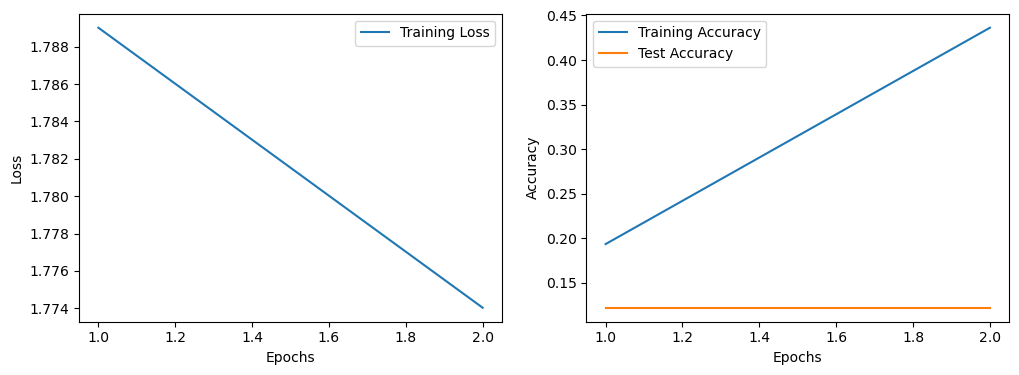

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [46]:
config = {
    'method': 'grid',
    'metric': {'name': 'Test Accuracy', 'goal': 'maximize'},
    'parameters': {
        'model_type': {'values': ['1D_CNN']},  
        'lstm_hidden_size': {'values': [32]},
        'lstm_num_layers': {'values': [2]},
        'pool_type': {'values': ['max']},
        'learning_rate': {'values': [0.01]},
        'epochs': {'values': [2]},
        'batch_size': {'values': [16]},
        'regularization': {'values': ['l1']},
        'regularization_strength': {'values': [0]},
        'optimizer': {'values': ['sgd']},
        'momentum': {'values': [0.5]},
        'time_step':{'values':[400]},  # length of one window
        # parameters of 1D CNN architecture   
        'kernel_size1': {'values': [3]},
        'kernel_size2': {'values': [3]},
        'out_1': {'values': [32]},  
        'out_2': {'values': [64]},
        'out_3': {'values': [128]},
        'dropout_rate': {'values': [0.1]}
    }
}

# load dataset1 with 400 timesteps, without overlapping
train_dataset = train_dataset1
test_dataset = test_dataset1


sweep_id = wandb.sweep(config, project="cdl-1dcnn-windows_para--test--", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

In [20]:
train_X = train_dataset.tensors[0]
train_y = train_dataset.tensors[1]
train_X.size(),train_X.transpose(1, 2).size(), train_y.size()

(torch.Size([408, 12, 400]), torch.Size([408, 400, 12]), torch.Size([408]))

### Compare four different dataset: use 200 or 400 time steps per window, without overlapping or with 50% overlapping
This means, here we don't tune any hyperparameters.

Create sweep with ID: ftcbg39y
Sweep URL: https://wandb.ai/weiping-zhang/cdl-1dcnn-windows_para/sweeps/ftcbg39y


wandb: Agent Starting Run: qflyy1g1 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 2
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.01
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


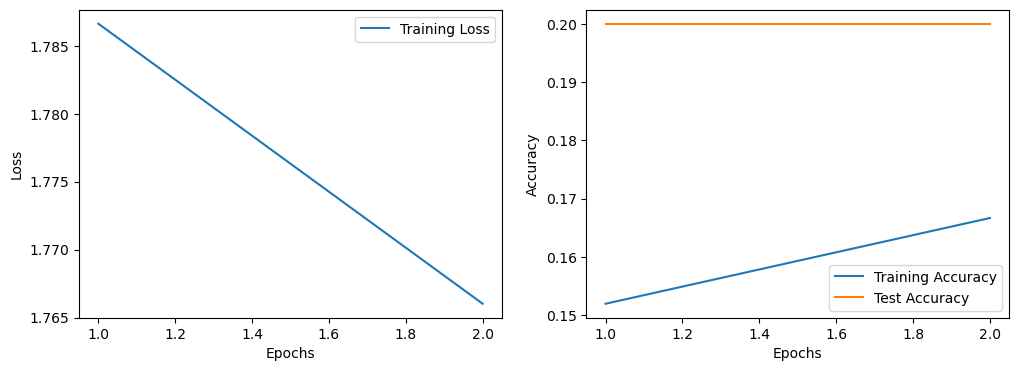

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [19]:
config = {
    'method': 'grid',
    'metric': {'name': 'Test Accuracy', 'goal': 'maximize'},
    'parameters': {
        'model_type': {'values': ['1D_CNN']},  
        'learning_rate': {'values': [0.01]},
        'epochs': {'values': [2]},
        'batch_size': {'values': [16]},
        'regularization': {'values': ['l1']},
        'regularization_strength': {'values': [0]},
        'optimizer': {'values': ['sgd']},
        'momentum': {'values': [0.5]},
        'time_step':{'values':[400]},  # length of one window
        # parameters of 1D CNN architecture   
        'kernel_size1': {'values': [3]},
        'kernel_size2': {'values': [3]},
        'out_1': {'values': [32]},  
        'out_2': {'values': [64]},
        'out_3': {'values': [128]},
        'max_pool': {'values': [2]},
        'dropout_rate': {'values': [0.1]}
    }
}

# load dataset1 with 400 timesteps, without overlapping
train_dataset = train_dataset1
test_dataset = test_dataset1


sweep_id = wandb.sweep(config, project="cdl-1dcnn-windows_para", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

In [13]:
# load dataset2 with 400 timesteps, with 50% overlapping
train_dataset = train_dataset2
test_dataset = test_dataset2
sweep_id = wandb.sweep(config, project="cdl-1dcnn-windows_para", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

# load dataset3 with 200 timesteps, without overlapping
train_dataset = train_dataset3
test_dataset = test_dataset3
config['parameters']['time_step']['values'] = [200] # update time_step
sweep_id = wandb.sweep(config, project="cdl-1dcnn-windows_para", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

# load dataset4 with 200 timesteps, with 50% overlapping
train_dataset = train_dataset4
test_dataset = test_dataset4
sweep_id = wandb.sweep(config, project="cdl-1dcnn-windows_para", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 42athqx2
Sweep URL: https://wandb.ai/weiping-zhang/cdl-1dcnn-windows_para/sweeps/42athqx2


wandb: Waiting for W&B process to finish... (success).
wandb: | 0.020 MB of 0.020 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:    Test Accuracy ▁▁▁▂▇▃▅▃██▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
wandb:   Train Accuracy ▁▁▁▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇█▇████████████████████
wandb:       Train Loss ██▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: estimation error ▁▁▁▄▃▆▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
wandb: 
wandb: Run summary:
wandb:    Test Accuracy 0.4
wandb:   Train Accuracy 0.99632
wandb:       Train Loss 1.05462
wandb: estimation error 0.59632
wandb: 
wandb: 🚀 View run mild-sweep-1 at: https://wandb.ai/weiping-zhang/cdl-1dcnn-windows_para/runs/2vfba1kd
wandb: Synced 6 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230425_210218-2vfba1kd/logs
wandb: Agent Starting Run: qhakstyo with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 1000
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.01
w

Exception in thread Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    NetStatThr:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
self.run()  File "/opt/anaconda3/lib/python3.9/threading.py", line 917, in run

  File "/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 277, in check_stop_status
        self._target(*self._args, **self._kwargs)self._loop_check_status(

  File "/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 259, in check_network_status
  File "/opt/anaconda3/lib/python3.9/site-packages/wandb/sdk/wandb_run.py", line 215, in _loop_check_status
    self._loop_check_status(
  File "/opt/anaconda3/lib/python3.9/site-packages/wandb/sd

: 

: 

### learning_rate and batch_size tuning: keep all other parameters fixed 

Create sweep with ID: n6qgjiqd
Sweep URL: https://wandb.ai/weiping-zhang/cdl-1dcnn-400_no-ol_lr_bs/sweeps/n6qgjiqd


wandb: Agent Starting Run: ihd13rz8 with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.1
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400
wandb: Currently logged in as: weiping-zhang. Use `wandb login --relogin` to force relogin


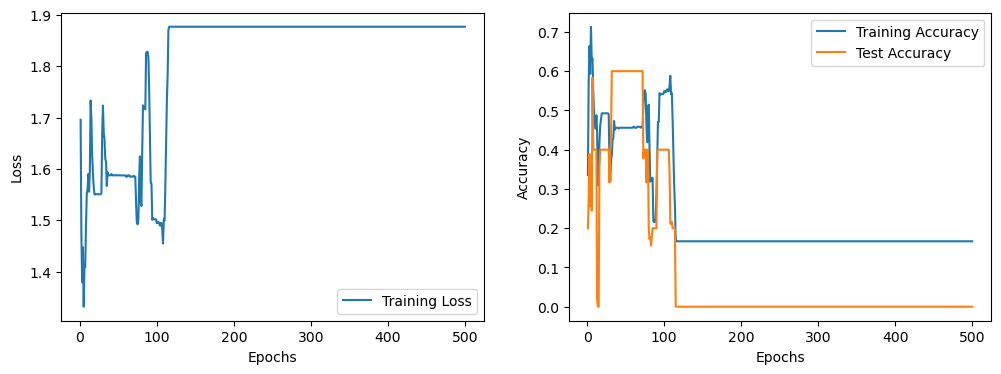

wandb: Agent Starting Run: r23ayp2e with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.01
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


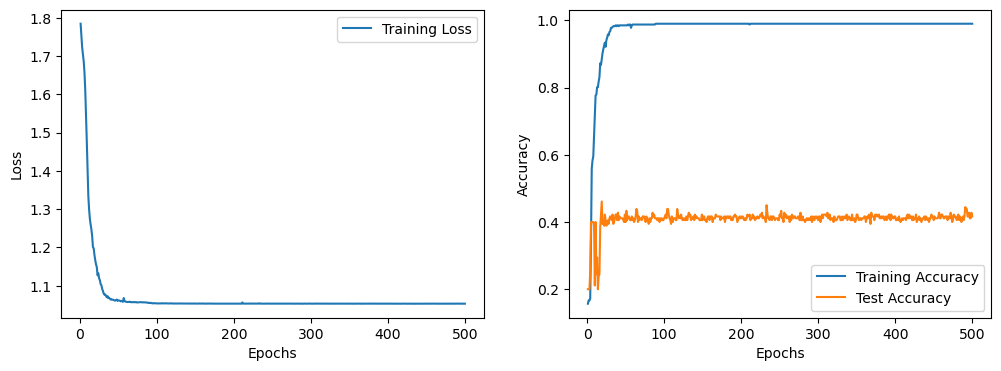

wandb: Agent Starting Run: dpwaievf with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.001
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


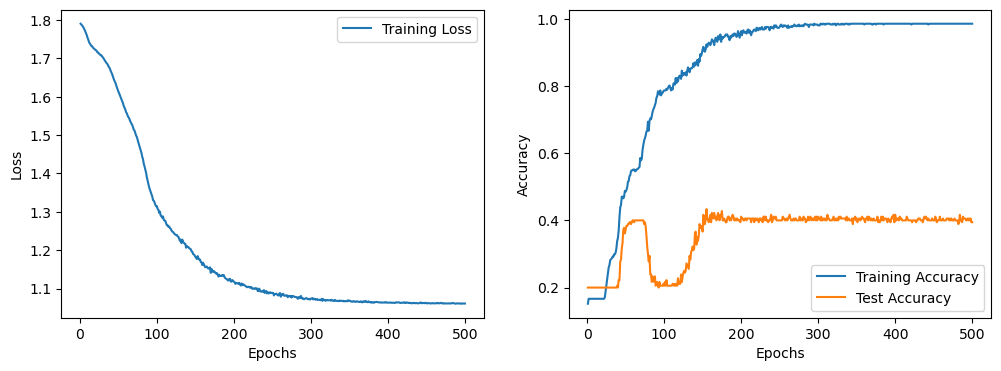

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lojndslx with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.1
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


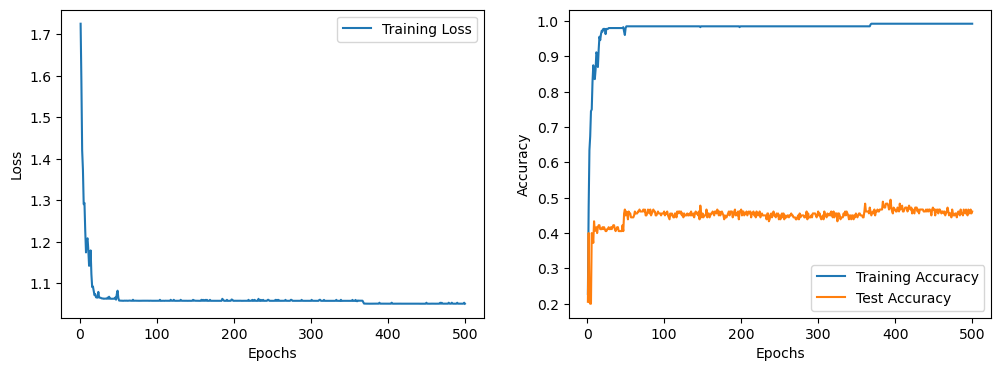

wandb: Agent Starting Run: ffeafpnz with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.01
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


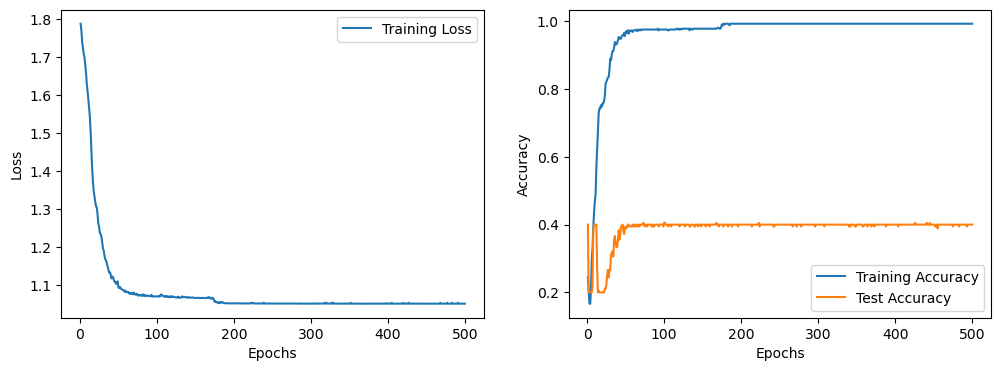

wandb: Agent Starting Run: 7jocdcf8 with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.001
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


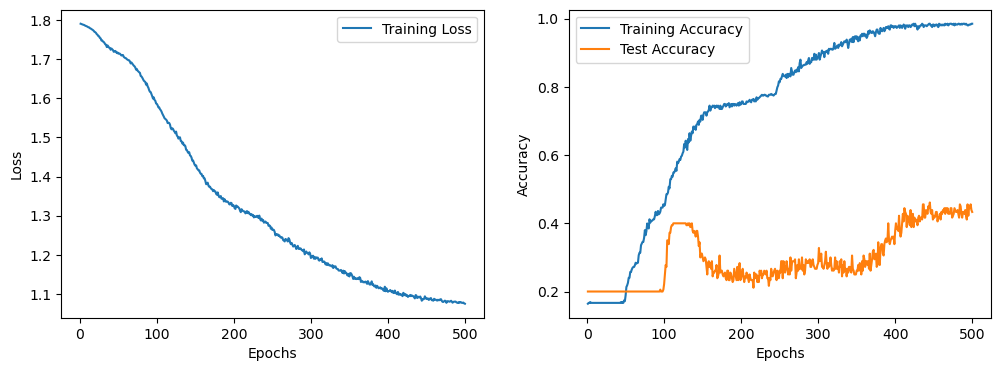

wandb: Agent Starting Run: fvg1lhug with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.1
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


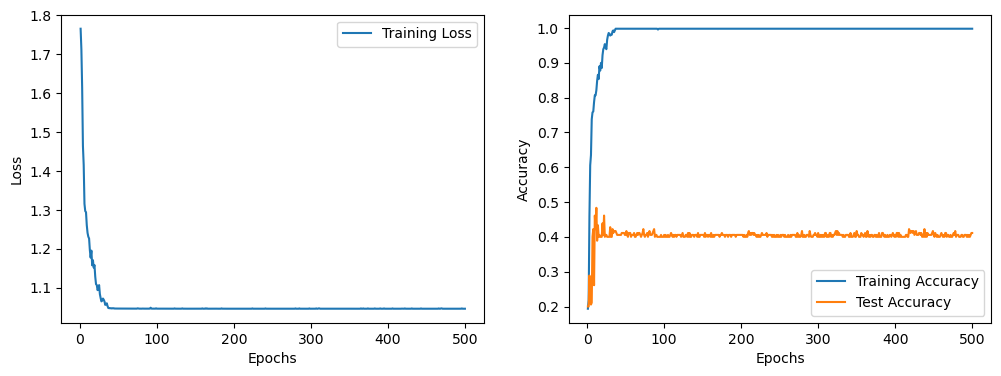

wandb: Agent Starting Run: 0474hha1 with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.01
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


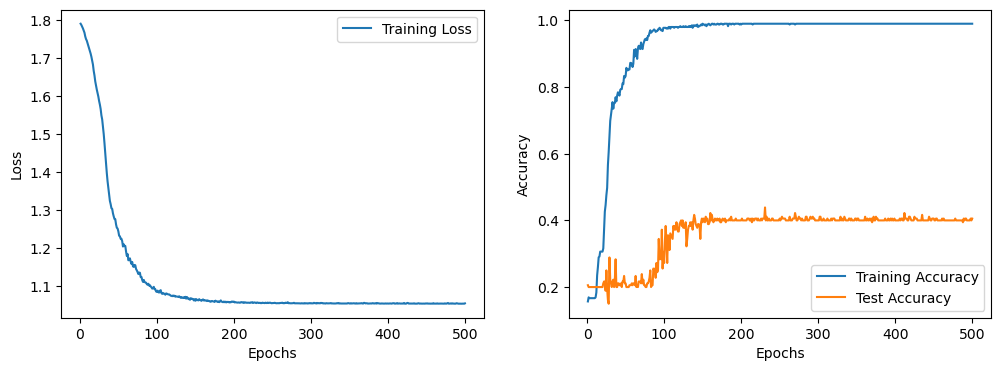

wandb: Agent Starting Run: p1csa2uj with config:
wandb: 	batch_size: 32
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.001
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


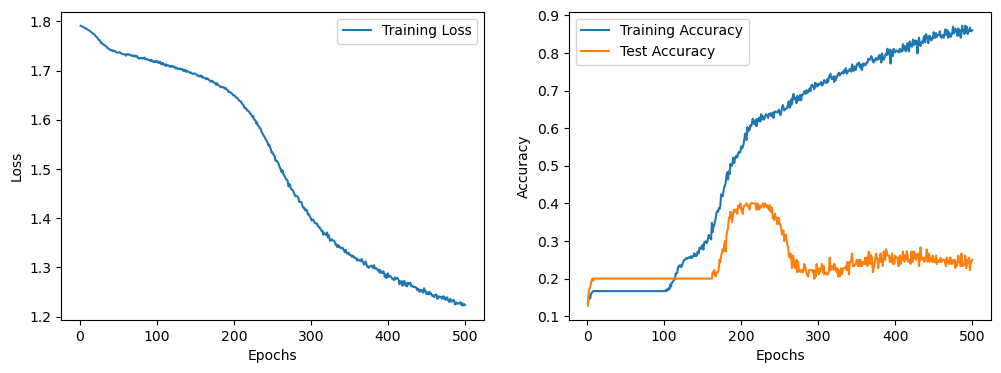

wandb: Agent Starting Run: l6u0j72g with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.1
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


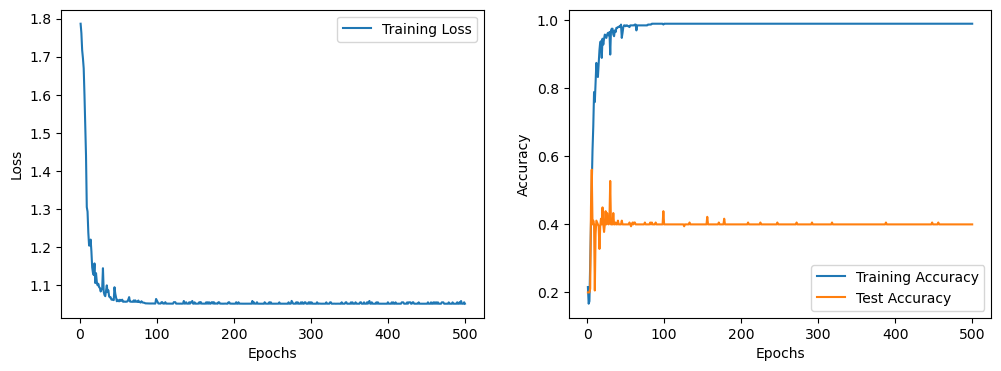

wandb: Agent Starting Run: bcpftndo with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.01
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


wandb: Agent Starting Run: rzhmedd6 with config:
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.001
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


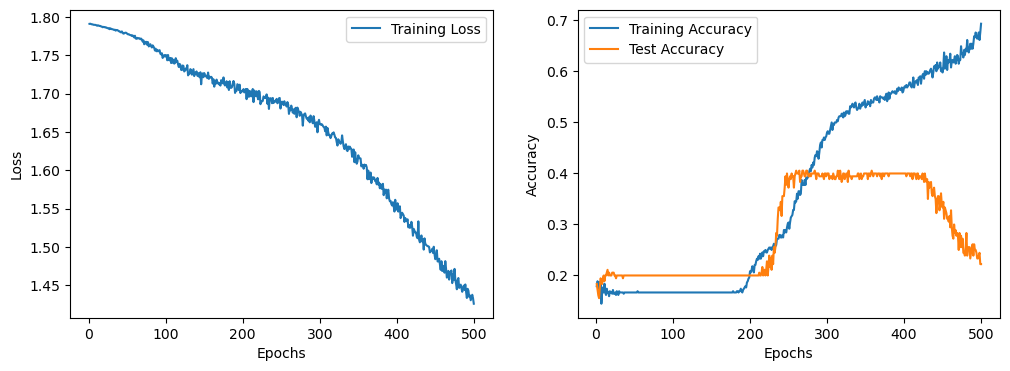

wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [8]:
# use group_1 dataset, 2 convolutional layers, 3 fully connected layer, 1D CNN architecture
# learning_rate tuning: keep all other parameters fixed 
config = {
    'method': 'grid',
    'metric': {'name': 'Test Accuracy', 'goal': 'maximize'},
    'parameters': {
        'model_type': {'values': ['1D_CNN']},  
        'learning_rate': {'values': [0.1, 0.01, 0.001]},
        'epochs': {'values': [500]},
        'batch_size': {'values': [8,16,32,64]},
        'regularization': {'values': ['l1']},
        'regularization_strength': {'values': [0]},
        'optimizer': {'values': ['sgd']},
        'momentum': {'values': [0.5]},
        'time_step':{'values':[400]},  # length of one window
        # parameters of 1D CNN architecture   
        'kernel_size1': {'values': [3]},
        'kernel_size2': {'values': [3]},
        'out_1': {'values': [32]},  
        'out_2': {'values': [64]},
        'out_3': {'values': [128]},
        'max_pool': {'values': [2]},
        'dropout_rate': {'values': [0.1]},  # Renamed to 'dropout_rate'
    }
}

train_dataset = train_dataset1
test_dataset = test_dataset1
#config['parameters']['time_step']['values'] = [time_step1] # update time_step

sweep_id = wandb.sweep(config, project="cdl-1dcnn-400_no-ol_lr_bs", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

Create sweep with ID: ph1h8v21
Sweep URL: https://wandb.ai/weiping-zhang/cdl-1dcnn-400_50-ol_lr_bs/sweeps/ph1h8v21


wandb: Agent Starting Run: lpzsf7po with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.1
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


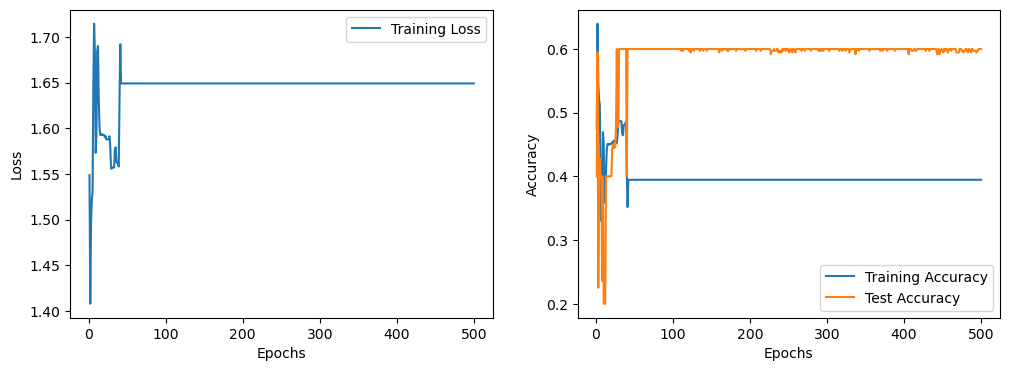

wandb: Agent Starting Run: ydm1o1aa with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.01
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


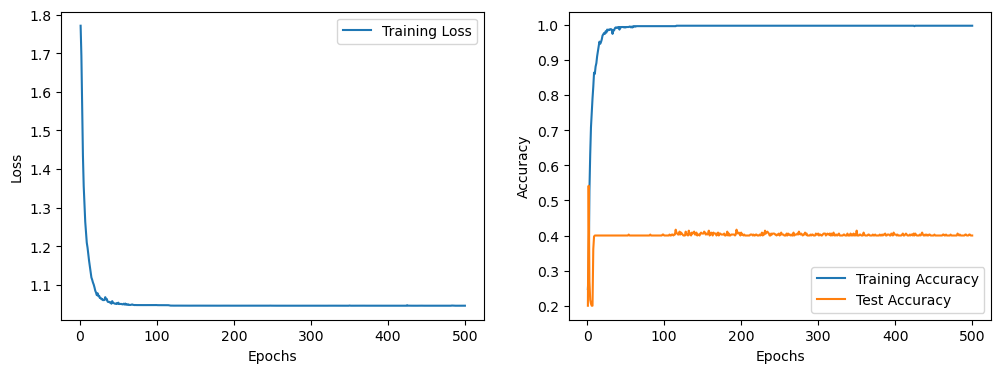

wandb: Agent Starting Run: fp5988ym with config:
wandb: 	batch_size: 8
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.001
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


wandb: Agent Starting Run: us1hr7bi with config:
wandb: 	batch_size: 16
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 500
wandb: 	kernel_size1: 3
wandb: 	kernel_size2: 3
wandb: 	learning_rate: 0.1
wandb: 	max_pool: 2
wandb: 	model_type: 1D_CNN
wandb: 	momentum: 0.5
wandb: 	optimizer: sgd
wandb: 	out_1: 32
wandb: 	out_2: 64
wandb: 	out_3: 128
wandb: 	regularization: l1
wandb: 	regularization_strength: 0
wandb: 	time_step: 400


: 

: 

In [9]:
# group_2 dataset, 2 convolutional layers, 3 fully connected layer, 1D CNN architecture
train_dataset = train_dataset2
test_dataset = test_dataset2
config['parameters']['time_step']['values'] = [time_step2] # update time_step

sweep_id = wandb.sweep(config, project="cdl-1dcnn-400_50-ol_lr_bs", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

In [ ]:
# group_3 dataset, 2 convolutional layers, 3 fully connected layer, 1D CNN architecture
train_dataset = train_dataset3
test_dataset = test_dataset3
config['parameters']['time_step']['values'] = [time_step3] # update time_step

sweep_id = wandb.sweep(config, project="cdl-1dcnn-200_no-ol_lr_bs", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

In [ ]:
# group_4 dataset, 2 convolutional layers, 3 fully connected layer, 1D CNN architecture
train_dataset = train_dataset4
test_dataset = test_dataset4
config['parameters']['time_step']['values'] = [time_step4] # update time_step

sweep_id = wandb.sweep(config, project="cdl-1dcnn-200_50-ol_lr_bs", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))

In [ ]:
stop

select learning_rate = 0.1
### batch_size tuning

In [ ]:

config['parameters']['batch_size']['values'] = [-]
config['parameters']['learning_rate']['values'] = [0.1]
sweep_id = wandb.sweep(config, project="cdl-1dcnn-lr-bs", entity="weiping-zhang")
wandb.agent(sweep_id, function=lambda: train_eval_model(config))


SyntaxError: invalid syntax (2093909955.py, line 1)

### 1D CNN

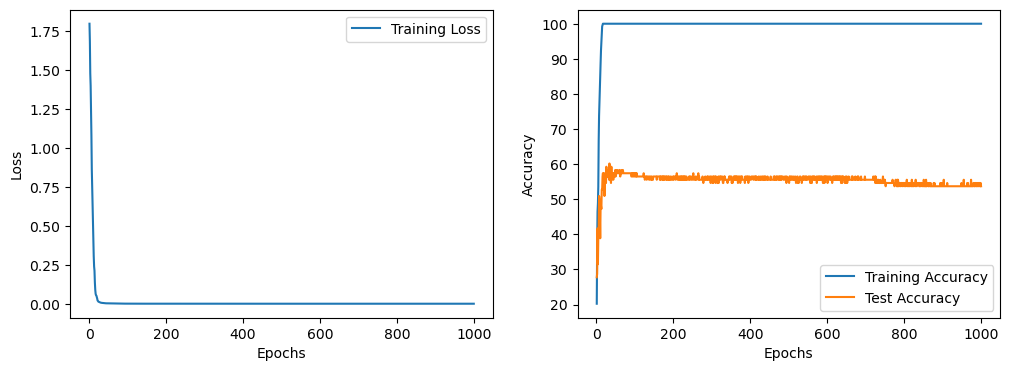

In [ ]:
# Adam 1D CNN
# Create the model, loss function, and optimizer
model = Simple1DCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train the 1D CNN and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)


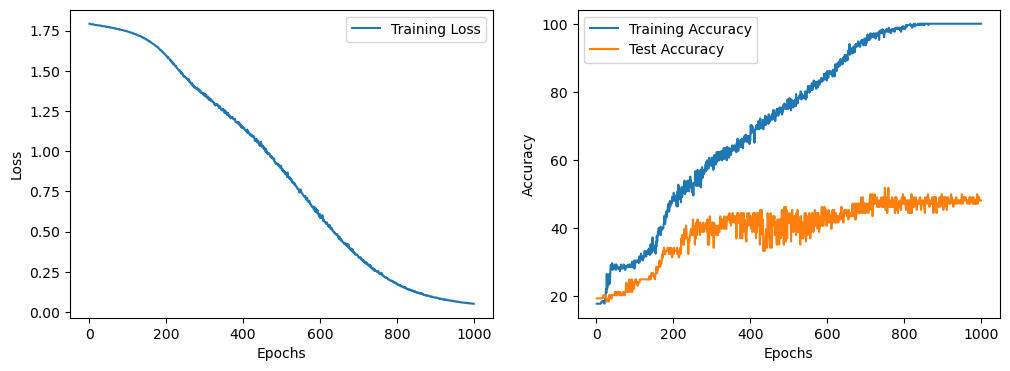

In [ ]:
# SGD 1D CNN: 2 layers
# Create the model, loss function, and optimizer
model = Simple1DCNN()# or SimpleLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Train the 1D CNN and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)

In [ ]:
# SGD 1D CNN: 1 layer
# Create the model, loss function, and optimizer
model = Simple1DCNN()# or SimpleLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Train the 1D CNN and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)

### LSTM

In [ ]:
# SGD LSTM 1000 epochs, 1 layer 

# Create the model, loss function, and optimizer
model = SimpleLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Train the 1D LSTM and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)

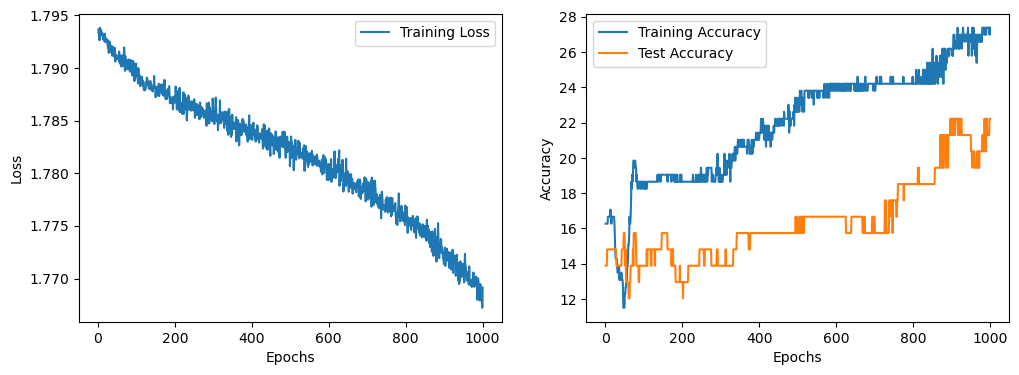

In [ ]:
# SGD LSTM 1000 epochs, 2 layers 

# Create the model, loss function, and optimizer
model = SimpleLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
# Train the 1D LSTM and evaluate the model
train_losses, train_accuracies, test_accuracies = train_eval_model(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=1000)

# Plot the results
plot_results(train_losses, train_accuracies, test_accuracies)